# State of the Problem 1: EFFECTS OF METEOROLOGICAL FACTORS TO DENGUE CASES

## PYTHON TOOLS NEEDED

In [45]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

## SEIR MODEL

In [46]:
# 1. Model with Meteorological Factors
def seir_sei_meteo(y, t, beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m, temp, rain, humidity):
    Sh, Eh, Ih, Rh, Sm, Em, Im = y

    temp_scaled = (temp[int(t)] - np.mean(temp)) / np.std(temp)
    rain_scaled = (rain[int(t)] - np.mean(rain)) / np.std(rain)
    humid_scaled = (humidity[int(t)] - np.mean(humidity)) / np.std(humidity)

    beta_h = beta_hv * (1 + 0.05 * temp_scaled + 0.05 * rain_scaled + 0.05 * humid_scaled)
    beta_m = beta_vh * (1 + 0.05 * temp_scaled + 0.05 * rain_scaled + 0.05 * humid_scaled)


    # Total populations
    N_h = Sh + Eh + Ih + Rh
    N_m = Sm + Em + Im
    
    # Human (SEIR) equations
    dShdt = mu_h * N_h - beta_h * Sh * Im / N_h - mu_h * Sh
    dEhdt = (beta_h * Sh * Im / N_h) - (sigma_h + mu_h) * Eh
    dIhdt = (sigma_h * Eh) - (gamma_h + mu_h) * Ih
    dRhdt = (gamma_h * Ih) - (mu_h * Rh)

    # Vector (SEI) equations
    dSmdt = A - beta_m * Sm * Ih / N_h - mu_m * Sm
    dEmdt = (beta_m * Sm * Ih / N_h) - (sigma_m + mu_m) * Em
    dImdt = (sigma_m * Em) - mu_m * Im

    return [dShdt, dEhdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [47]:
# 2. Model without Meteorological Factors
def seir_sei_model(y, t, beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m):
    Sh, Eh, Ih, Rh, Sm, Em, Im = y

    # Total populations
    N_h = Sh + Eh + Ih + Rh
    N_m = Sm + Em + Im
    
    # Human (SEIR) equations
    dShdt = mu_h * N_h - beta_hv * Sh * Im / N_h - mu_h * Sh
    dEhdt = (beta_hv * Sh * Im / N_h) - (sigma_h + mu_h) * Eh
    dIhdt = (sigma_h * Eh) - (gamma_h + mu_h) * Ih
    dRhdt = (gamma_h * Ih) - (mu_h * Rh)

    # Vector (SEI) equations
    dSmdt = A - beta_vh * Sm * Ih / N_h - mu_m * Sm
    dEmdt = (beta_vh * Sm * Ih / N_h) - (sigma_m + mu_m) * Em
    dImdt = (sigma_m * Em) - mu_m * Im

    return [dShdt, dEhdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

## ACCURACY EVALUATION CALCULATION

In [48]:
# Function to evaluate model accuracy
def evaluate_model(y_true, y_pred):
    """Calculates RMSE and R-squared."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r_squared = r2_score(y_true, y_pred)
    return rmse, r_squared

## SIMULATION AND EVALUATION

In [49]:
dengue_cases = pd.read_csv('2023_cases_x_larvae.csv')

beta_hv = 1/30       # Human-to-vector transmission rate
sigma_h = 1/10       # Human incubation period (5 days)
gamma_h = 1/10      # Human infectious period (10 days)
mu_h = 1/(70*365)   # Human life expectancy (70 years)
A = 44.5            # Mosquito recruitment rate
mu_m = 1/14         # Mosquito lifespan (14 days)
beta_vh = 1/30       # Vector-to-human transmission rate
sigma_m = 1/15      # Mosquito incubation period (10 days)

# human cases primary value
N_h =  dengue_cases['Total_Population'].iloc[-1]
I_h0 = dengue_cases['New_cases'].iloc[-1]
E_h0 = 0
R_h0 = dengue_cases['Total_cases'].iloc[-1]
S_h0 = N_h - I_h0 - E_h0 - R_h0

# mosquito primnary value
N_m = dengue_cases['Total_Mosquito_Population'].iloc[-1]
I_m0 = dengue_cases['Total_Mosquito_Population'].iloc[-1] * 44.5
E_m0 = 0
S_m0 = N_m - I_m0 - E_m0

y0 = [S_h0, E_h0, I_h0, R_h0, S_m0, E_m0, I_m0]


# Time array for a 90-day simulation
time_array = np.arange(0, 90)

# querying data for First Quarter (Jan, Feb, March)
first_quarter_data = dengue_cases.query('Month_Num == 1 | Month_Num == 2 | Month_Num == 3') 

# average temperature for 1st quarter
jan_temp = first_quarter_data.query('Month_Num == 1')['TMEAN'].mean()       # average temperature for January
feb_temp = first_quarter_data.query('Month_Num == 2')['TMEAN'].mean()       # average temperature for February
mar_temp = first_quarter_data.query('Month_Num == 3')['TMEAN'].mean()       # average temperature for March

# average rainfall for 1st quarter
jan_rain = first_quarter_data.query('Month_Num == 1')['RAINFALL'].mean()    # average rainfall for January
feb_rain = first_quarter_data.query('Month_Num == 2')['RAINFALL'].mean()    # average rainfall for February
mar_rain = first_quarter_data.query('Month_Num == 3')['RAINFALL'].mean()    # average rainfall for March

# average humidity for 1st quarter
jan_humidity = first_quarter_data.query('Month_Num == 1')['RH'].mean()          # average humidity for January
feb_humidity = first_quarter_data.query('Month_Num == 2')['RH'].mean()          # average humidity for February
mar_humidity = first_quarter_data.query('Month_Num == 3')['RH'].mean()          # average humidity for March

monthly_ave_temp = [jan_temp, feb_temp, mar_temp]
monthly_ave_rain = [jan_rain, feb_rain, mar_rain]
monthly_ave_humidity = [jan_humidity, feb_humidity, mar_humidity]

# Set standard deviations (you can adjust these depending on how much variation you want)
temp_std = np.std(dengue_cases['TMEAN'])    # temperature variation (°C)
rain_std = np.std(dengue_cases['RAINFALL']) # rainfall variation (mm)
humidity_std = np.std(dengue_cases['RH'])   # humidity variation (%)

# Reset daily lists
temp_daily = []
rain_daily = []
humidity_daily = []

days_in_month = 30
for i in range(len(monthly_ave_temp)):
    # Generate random values around the mean for each month
    temps = np.random.normal(monthly_ave_temp[i], temp_std, days_in_month)
    rains = np.random.normal(monthly_ave_rain[i], rain_std, days_in_month)
    humids = np.random.normal(monthly_ave_humidity[i], humidity_std, days_in_month)

    # Ensure values stay within reasonable bounds
    rains = np.clip(rains, 0, None)          # rainfall can't be negative
    humids = np.clip(humids, 0, 100)         # humidity is 0–100%

    temp_daily.extend(temps)
    rain_daily.extend(rains)
    humidity_daily.extend(humids)

### Simulation 1: SEIR forecast with Meteorological Data

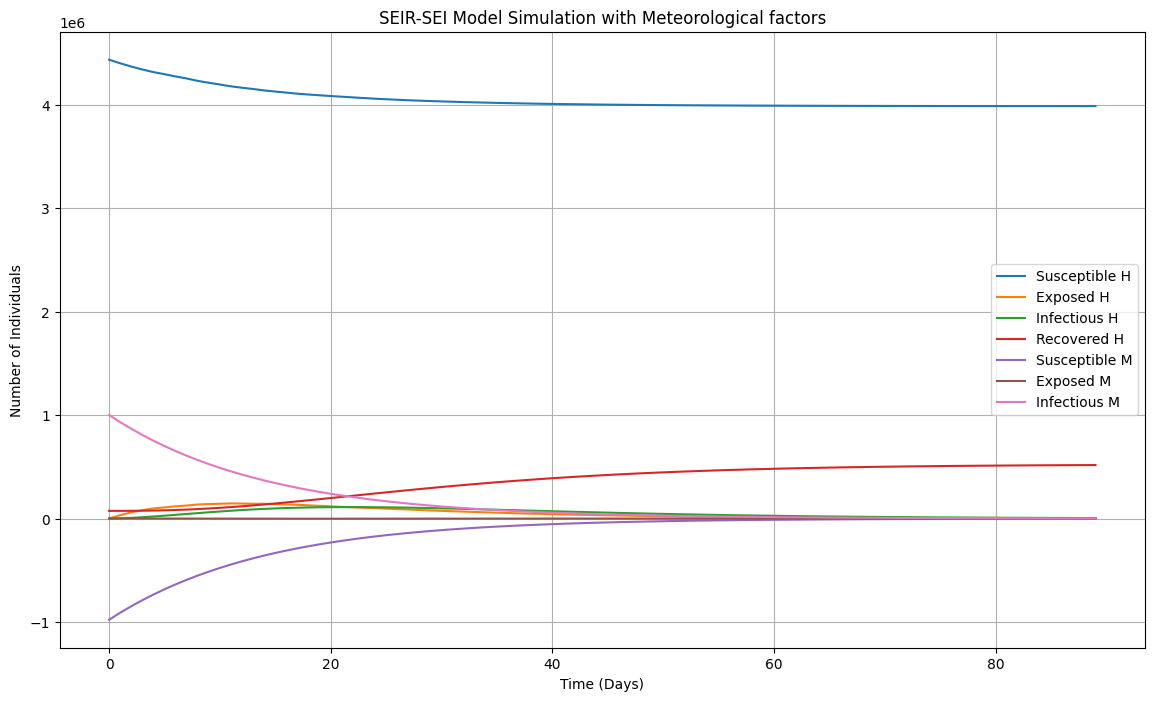

In [50]:
solution_meteo = odeint(seir_sei_meteo, y0, time_array, args=(beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m, temp_daily, rain_daily, humidity_daily))
simulated_cases_meteo = solution_meteo[:, 2] # Index 2 is the 'I' (Infected) compartment

Sh, Eh, Ih, Rh, Sm, Em, Im = solution_meteo.T # Transpose the solution to get S, E, I, R, S, E, I as separate arrays

# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, Sh, label='Susceptible H')
plt.plot(time_array, Eh, label='Exposed H')
plt.plot(time_array, Ih, label='Infectious H')
plt.plot(time_array, Rh, label='Recovered H')
plt.plot(time_array, Sm, label='Susceptible M')
plt.plot(time_array, Em, label='Exposed M')
plt.plot(time_array, Im, label='Infectious M')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Individuals')
plt.title('SEIR-SEI Model Simulation with Meteorological factors')
plt.legend()
plt.grid(True)
plt.show()

### Simulation 2: Standard SEIR forecast 

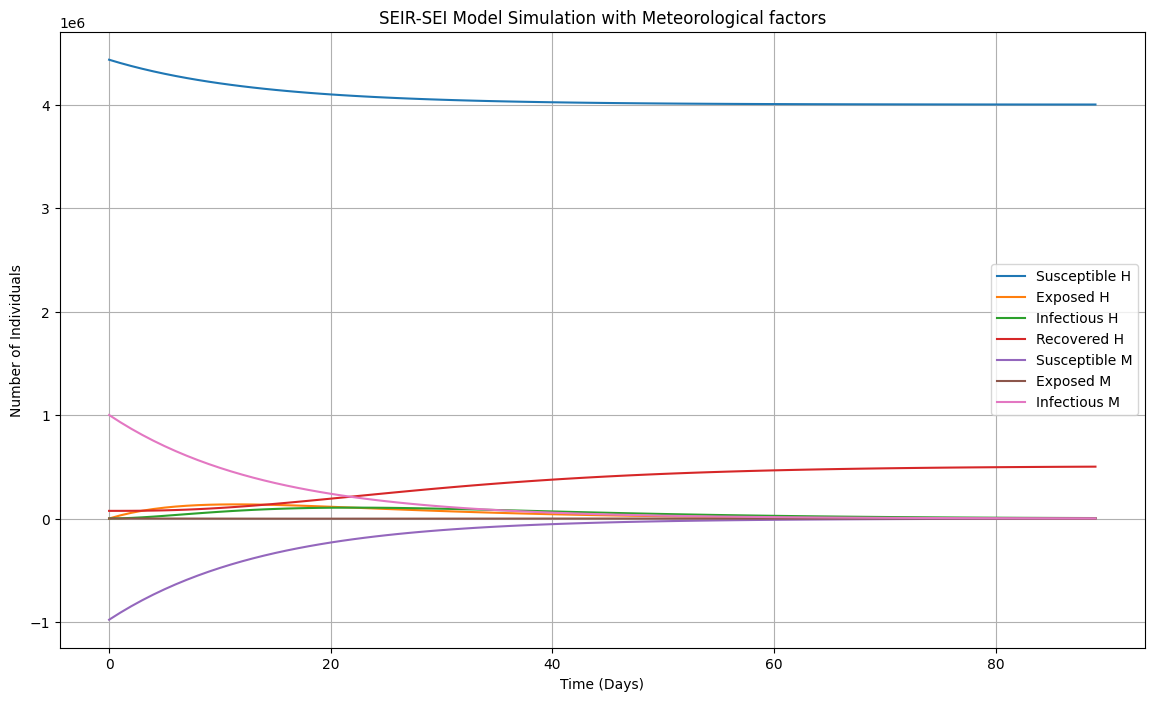

In [54]:
solution = odeint(seir_sei_model, y0, time_array, args=(beta_hv, sigma_h, gamma_h, mu_h, A, mu_m, beta_vh, sigma_m))
simulated_cases_no_meteo = solution[:, 2] # Index 2 is the 'I' (Infected) compartment

Sh, Eh, Ih, Rh, Sm, Em, Im = solution.T # Transpose the solution to get S, E, I, R, S, E, I as separate arrays

SEIR_SEI = pd.DataFrame({
    'Sh': Sh,
    'Eh': Eh,
    'Ih': Ih,
    'Rh': Rh,
    'Sm': Sm,
    'Em': Em,
    'Im': Im
})

SEIR_SEI.to_csv('SEIR-SEI.csv', mode='w', index=False)


# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, Sh, label='Susceptible H')
plt.plot(time_array, Eh, label='Exposed H')
plt.plot(time_array, Ih, label='Infectious H')
plt.plot(time_array, Rh, label='Recovered H')
plt.plot(time_array, Sm, label='Susceptible M')
plt.plot(time_array, Em, label='Exposed M')
plt.plot(time_array, Im, label='Infectious M')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Individuals')
plt.title('SEIR-SEI Model Simulation with Meteorological factors')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Observed data (using our actual data from the past `t` days)
dc = pd.read_csv('cleaned_dengue_data.csv')
observed_cases = dc['New_cases'].tail(len(time_array)).values

## STATISTICAL ANALYSIS AND COMPARISON

In [53]:
# Evaluate the model with meteorological factors
rmse_meteo, r2_meteo = evaluate_model(observed_cases, simulated_cases_meteo)
print(f"Model WITH Meteorological Factors:")
print(f"  RMSE: {rmse_meteo:.2f}")
print(f"  R-squared: {r2_meteo:.2f}")

print("-" * 30)

# Evaluate the model without meteorological factors
rmse_no_meteo, r2_no_meteo = evaluate_model(observed_cases, simulated_cases_no_meteo)
print(f"Model WITHOUT Meteorological Factors:")
print(f"  RMSE: {rmse_no_meteo:.2f}")
print(f"  R-squared: {r2_no_meteo:.2f}")

# SOP 1: Comparison
print("-" * 30)
if rmse_meteo < rmse_no_meteo and r2_meteo > r2_no_meteo:
    print("Conclusion: Including meteorological factors IMPROVES forecast accuracy.")
    print("The factors have a significant effect on dengue transmission.")
else:
    print("Conclusion: Including meteorological factors does NOT improve forecast accuracy.")
    print("The factors may not have a significant effect, or the model's formulation needs adjustment.")

Model WITH Meteorological Factors:
  RMSE: 61029.93
  R-squared: -5745.03
------------------------------
Model WITHOUT Meteorological Factors:
  RMSE: 58596.88
  R-squared: -5296.01
------------------------------
Conclusion: Including meteorological factors does NOT improve forecast accuracy.
The factors may not have a significant effect, or the model's formulation needs adjustment.
